In [1]:
import random 
from types import SimpleNamespace

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np

import torch
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [2]:
import sys
import os
from pathlib import Path

parent = Path(os.path.abspath("")).resolve().parents[0]
if parent not in sys.path:
    sys.path.insert(0, str(parent))
    
from ml.utils.data_utils import TorchDataset
from ml.utils.metrics import get_classification_metrics, get_probability_measures, get_lift_demotion_scores

from ml.models.autoencoder import AutoEncoder
from ml.models.mlp import MLP

In [3]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
def merge_strings_and_integers(val):
    try:
        return int(val)
    except:
        return 'other'

In [5]:
df = pd.read_csv("final_autof.csv")
df.drop([
    'MODE(consumptions.MS_METER_NBR)',
    'MODE(representations.SUPPLIER)',
    'MODE(representations.SUPPLIER_TO)',
], axis=1, inplace=True)
df.dropna(subset=['number_of_zeros'], inplace=True)


df['MODE(consumptions.BS_RATE)'] = df['MODE(consumptions.BS_RATE)'].apply(merge_strings_and_integers)
df = df.drop(['rec_id'], axis=1)
df = df.drop_duplicates()
df['MODE(requests.REQUEST_TYPE)'] = df['MODE(requests.REQUEST_TYPE)'].replace(0, 'unknown')
df = pd.get_dummies(df, columns=['MODE(requests.REQUEST_TYPE)'], prefix='MODE(requests.REQUEST_TYPE)')
df = pd.get_dummies(df, columns=['MODE(consumptions.BS_RATE)'], prefix='MODE(consumptions.BS_RATE)')
df = df.drop(['voltage'], axis=1)
df.fillna(0, inplace=True)
df.head()

/tmp/ipykernel_17054/3053899110.py:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("final_autof.csv")


,COUNT(consumptions),MAX(consumptions.CSS_MS_HS_USE),MEAN(consumptions.CSS_MS_HS_USE),MIN(consumptions.CSS_MS_HS_USE),NUM_UNIQUE(consumptions.BS_RATE),NUM_UNIQUE(consumptions.MS_METER_NBR),SKEW(consumptions.CSS_MS_HS_USE),STD(consumptions.CSS_MS_HS_USE),SUM(consumptions.CSS_MS_HS_USE),MODE(consumptions.DAY(MEASUREMENT_DATE)),...,MODE(consumptions.BS_RATE)_40,MODE(consumptions.BS_RATE)_41,MODE(consumptions.BS_RATE)_42,MODE(consumptions.BS_RATE)_43,MODE(consumptions.BS_RATE)_44,MODE(consumptions.BS_RATE)_52,MODE(consumptions.BS_RATE)_53,MODE(consumptions.BS_RATE)_54,MODE(consumptions.BS_RATE)_55,MODE(consumptions.BS_RATE)_other
0,4.0,135.0,64.250000,12.0,1.0,1.0,0.758461,54.389797,257.0,2.0,...,0,0,0,0,0,0,0,0,0,0
1,10.0,127.0,51.900000,0.0,1.0,2.0,0.783315,43.072162,519.0,2.0,...,0,0,0,0,0,0,0,0,0,0
2,12.0,6068.0,3924.166667,2446.0,1.0,1.0,0.574519,1012.516472,47090.0,28.0,...,0,0,0,0,0,0,0,0,0,0
3,6.0,1061.0,479.333333,7.0,2.0,1.0,0.020392,409.340282,2876.0,4.0,...,0,0,0,0,0,0,0,0,0,0
4,24.0,1247.0,536.833333,0.0,2.0,1.0,0.537625,335.364392,12884.0,4.0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
df = df.drop_duplicates()
print(len(df.loc[df.target == 1]))
df.head()

1552


,COUNT(consumptions),MAX(consumptions.CSS_MS_HS_USE),MEAN(consumptions.CSS_MS_HS_USE),MIN(consumptions.CSS_MS_HS_USE),NUM_UNIQUE(consumptions.BS_RATE),NUM_UNIQUE(consumptions.MS_METER_NBR),SKEW(consumptions.CSS_MS_HS_USE),STD(consumptions.CSS_MS_HS_USE),SUM(consumptions.CSS_MS_HS_USE),MODE(consumptions.DAY(MEASUREMENT_DATE)),...,MODE(consumptions.BS_RATE)_40,MODE(consumptions.BS_RATE)_41,MODE(consumptions.BS_RATE)_42,MODE(consumptions.BS_RATE)_43,MODE(consumptions.BS_RATE)_44,MODE(consumptions.BS_RATE)_52,MODE(consumptions.BS_RATE)_53,MODE(consumptions.BS_RATE)_54,MODE(consumptions.BS_RATE)_55,MODE(consumptions.BS_RATE)_other
0,4.0,135.0,64.250000,12.0,1.0,1.0,0.758461,54.389797,257.0,2.0,...,0,0,0,0,0,0,0,0,0,0
1,10.0,127.0,51.900000,0.0,1.0,2.0,0.783315,43.072162,519.0,2.0,...,0,0,0,0,0,0,0,0,0,0
2,12.0,6068.0,3924.166667,2446.0,1.0,1.0,0.574519,1012.516472,47090.0,28.0,...,0,0,0,0,0,0,0,0,0,0
3,6.0,1061.0,479.333333,7.0,2.0,1.0,0.020392,409.340282,2876.0,4.0,...,0,0,0,0,0,0,0,0,0,0
4,24.0,1247.0,536.833333,0.0,2.0,1.0,0.537625,335.364392,12884.0,4.0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
print("Bincount of y:", df['target'].value_counts())

Bincount of y: 0.0    698967
1.0      1552
Name: target, dtype: int64


In [8]:
train, val = train_test_split(
    df, test_size=0.2, 
    random_state=42, shuffle=True, 
    stratify=df.target.values)

In [9]:
train.target.value_counts(), val.target.value_counts()

(0.0    559173
 1.0      1242
 Name: target, dtype: int64,
 0.0    139794
 1.0       310
 Name: target, dtype: int64)

In [10]:
X_train = train.drop('target', axis=1)
y_train = train['target']
X_val = val.drop('target', axis=1)
y_val = val['target']

In [11]:
scaler = MinMaxScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)

In [12]:
train_dataset = TorchDataset(
    X=torch.tensor(X_train).float(),
    y=torch.tensor(y_train.to_numpy()).float()
)  # reconstruction
val_dataset = TorchDataset(
    X=torch.tensor(X_val).float(),
    y=torch.tensor(y_val.to_numpy()).float()
)

In [13]:
np.bincount(y_train), np.bincount(y_val)

(array([559173,   1242]), array([139794,    310]))

In [14]:
train_loader = DataLoader(
    train_dataset, batch_size=512, shuffle=False
)
val_loader = DataLoader(
    val_dataset, batch_size=512, shuffle=False
)

In [15]:
encoder = MLP(
    in_size=X_train.shape[1],
    layer_units=[64],
    out_size=32,
    vae=False) # do not use VAE
decoder = MLP(
    in_size=32, 
    layer_units=[64],
    out_size=X_train.shape[1]
)
classifier = MLP(
    in_size=X_train.shape[1],
    layer_units=[32, 64],
    out_size=1,
    init_weights=False
)
model = AutoEncoder(encoder, decoder, classifier=classifier) # make it an AutoEncoder-based classifier.
model

AutoEncoder(
  (encoder): MLP(
    (MLP): Sequential(
      (0): Linear(in_features=88, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=32, bias=True)
    )
  )
  (decoder): MLP(
    (MLP): Sequential(
      (0): Linear(in_features=32, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=88, bias=True)
    )
  )
  (classifier): MLP(
    (MLP): Sequential(
      (0): Linear(in_features=88, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=64, bias=True)
      (3): ReLU()
      (4): Linear(in_features=64, out_features=1, bias=True)
    )
  )
)

In [16]:
optimizer = torch.optim.Adam(model.parameters(), 
                                 lr=1e-3)
criterion = torch.nn.BCEWithLogitsLoss()
#device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'
print(device)
    
args = dict(
    model=model,
    train_loader=train_loader, 
    test_loader=val_loader,
    epochs=100, 
    optimizer=optimizer, 
    criterion=criterion,
    reconstruction=False,
    vae=False,
    device=device,
    verbose=True, 
    return_best=True,
    plot_history=True,
    num_test_samples=100
)

cpu


Epoch: 1/100
[Train]	Loss=0.027047121060318972, Accuracy: 0.9977837852305881, Precision: 0.0, Recall: 0.0, F1: 0.0
		Brier score loss: 0.002204095598180607, ROC-AUC: 0.8280342450630731, PR-AUC: 0.014587280682164831
		Lift: 0.07, Demotion: 1.0, Weighted Score: 0.349
[Test]	Loss=0.017802508547902107, Accuracy: 0.9977873579626563, Precision: 0.0, Recall: 0.0, F1: 0.0
		Brier score loss: 0.0022010393272768234, ROC-AUC: 0.8206967094900469, PR-AUC: 0.016138812926380038
		Lift: 0.03, Demotion: 1.0, Weighted Score: 0.321

Epoch: 2/100
[Train]	Loss=0.013942869430775733, Accuracy: 0.9977837852305881, Precision: 0.0, Recall: 0.0, F1: 0.0
		Brier score loss: 0.002183056282520547, ROC-AUC: 0.8702924934005009, PR-AUC: 0.04608634590312404
		Lift: 0.31, Demotion: 1.0, Weighted Score: 0.517
[Test]	Loss=0.017268972471356392, Accuracy: 0.9977873579626563, Precision: 0.0, Recall: 0.0, F1: 0.0
		Brier score loss: 0.0021798072726212075, ROC-AUC: 0.870751490557304, PR-AUC: 0.03643385279652138
		Lift: 0.12, D

[Test]	Loss=0.012502188794314861, Accuracy: 0.9977944955176155, Precision: 0.5714285714285714, Recall: 0.012903225806451613, F1: 0.025236593059936908
		Brier score loss: 0.0021374459035058157, ROC-AUC: 0.8837222119921155, PR-AUC: 0.064232321334277
		Lift: 0.19, Demotion: 1.0, Weighted Score: 0.43299999999999994

Epoch: 16/100
[Train]	Loss=0.011966978060453704, Accuracy: 0.9978605140833132, Precision: 0.9574468085106383, Recall: 0.036231884057971016, F1: 0.06982156710628394
		Brier score loss: 0.002044460146721877, ROC-AUC: 0.90886656926437, PR-AUC: 0.13803525633682132
		Lift: 0.78, Demotion: 1.0, Weighted Score: 0.8459999999999999
[Test]	Loss=0.012329176999628544, Accuracy: 0.9977944955176155, Precision: 0.5454545454545454, Recall: 0.01935483870967742, F1: 0.037383177570093455
		Brier score loss: 0.0021438634605798986, ROC-AUC: 0.8834967535179644, PR-AUC: 0.06282638155190667
		Lift: 0.17, Demotion: 1.0, Weighted Score: 0.419

Epoch: 17/100
[Train]	Loss=0.011923237959003782, Accuracy: 0

Epoch: 29/100
[Train]	Loss=0.011378833307612466, Accuracy: 0.9979033394894855, Precision: 0.8941176470588236, Recall: 0.061191626409017714, F1: 0.1145440844009043
		Brier score loss: 0.001989489865896758, ROC-AUC: 0.9189624951453426, PR-AUC: 0.16941927292388248
		Lift: 0.83, Demotion: 1.0, Weighted Score: 0.881
[Test]	Loss=0.01360675785690546, Accuracy: 0.9977659452977788, Precision: 0.42105263157894735, Recall: 0.025806451612903226, F1: 0.048632218844984795
		Brier score loss: 0.002158976305077508, ROC-AUC: 0.884695648943353, PR-AUC: 0.06713896247944169
		Lift: 0.18, Demotion: 1.0, Weighted Score: 0.426

Epoch: 30/100
[Train]	Loss=0.011325184656009419, Accuracy: 0.9979140458410285, Precision: 0.9397590361445783, Recall: 0.06280193236714976, F1: 0.11773584905660378
		Brier score loss: 0.0019859762019810994, ROC-AUC: 0.9208997288677693, PR-AUC: 0.17265652396500558
		Lift: 0.89, Demotion: 1.0, Weighted Score: 0.923
[Test]	Loss=0.01467135176062584, Accuracy: 0.9977588077428197, Precision:

[Test]	Loss=0.014787368476390839, Accuracy: 0.9976874321932279, Precision: 0.3055555555555556, Recall: 0.035483870967741936, F1: 0.06358381502890173
		Brier score loss: 0.002218281760228175, ROC-AUC: 0.8624885026677503, PR-AUC: 0.05497778654997051
		Lift: 0.16, Demotion: 1.0, Weighted Score: 0.412

Epoch: 43/100
[Train]	Loss=0.010792533498253145, Accuracy: 0.997976499558363, Precision: 0.8802816901408451, Recall: 0.10064412238325282, F1: 0.18063583815028902
		Brier score loss: 0.0019329139435315546, ROC-AUC: 0.9278023757266356, PR-AUC: 0.2042059673719025
		Lift: 0.96, Demotion: 1.0, Weighted Score: 0.972
[Test]	Loss=0.01387118548154831, Accuracy: 0.9976588819733911, Precision: 0.25, Recall: 0.02903225806451613, F1: 0.05202312138728324
		Brier score loss: 0.002227527792800489, ROC-AUC: 0.8643821415566777, PR-AUC: 0.05188463991151347
		Lift: 0.19, Demotion: 1.0, Weighted Score: 0.43299999999999994

Epoch: 44/100
[Train]	Loss=0.010796987772844817, Accuracy: 0.9979675775987438, Precision: 

Epoch: 56/100
[Train]	Loss=0.01027323580129055, Accuracy: 0.9978962019217901, Precision: 0.6075085324232082, Recall: 0.143317230273752, F1: 0.23192182410423454
		Brier score loss: 0.0019375174151230585, ROC-AUC: 0.9330216770002069, PR-AUC: 0.2219049853482038
		Lift: 0.94, Demotion: 1.0, Weighted Score: 0.958
[Test]	Loss=0.016147974878549576, Accuracy: 0.9975660937589219, Precision: 0.20754716981132076, Recall: 0.035483870967741936, F1: 0.06060606060606061
		Brier score loss: 0.0023384889666345377, ROC-AUC: 0.8639521424843098, PR-AUC: 0.044611515020589396
		Lift: 0.15, Demotion: 1.0, Weighted Score: 0.40499999999999997

Epoch: 57/100
[Train]	Loss=0.01036936298425237, Accuracy: 0.9980032654372206, Precision: 0.847457627118644, Recall: 0.12077294685990338, F1: 0.21141649048625794
		Brier score loss: 0.0018889376181521057, ROC-AUC: 0.9334397907263743, PR-AUC: 0.23463591156617752
		Lift: 0.96, Demotion: 1.0, Weighted Score: 0.972
[Test]	Loss=0.015203813090920448, Accuracy: 0.997651744418432

[Test]	Loss=0.01771186664700508, Accuracy: 0.9975232684291669, Precision: 0.12244897959183673, Recall: 0.01935483870967742, F1: 0.033426183844011144
		Brier score loss: 0.0023646506578500425, ROC-AUC: 0.8550866320812144, PR-AUC: 0.030424916857796504
		Lift: 0.1, Demotion: 1.0, Weighted Score: 0.37

Epoch: 70/100
[Train]	Loss=0.009704486069750023, Accuracy: 0.9980353844918498, Precision: 0.8133333333333334, Recall: 0.1473429951690821, F1: 0.2494887525562372
		Brier score loss: 0.0018361218090373812, ROC-AUC: 0.937469884679852, PR-AUC: 0.2687335887183352
		Lift: 0.95, Demotion: 1.0, Weighted Score: 0.9649999999999999
[Test]	Loss=0.01758473552763462, Accuracy: 0.9975304059841261, Precision: 0.125, Recall: 0.01935483870967742, F1: 0.033519553072625705
		Brier score loss: 0.0023671776228886884, ROC-AUC: 0.8576108416670244, PR-AUC: 0.034001379231296425
		Lift: 0.09, Demotion: 1.0, Weighted Score: 0.363

Epoch: 71/100
[Train]	Loss=0.009755854531654824, Accuracy: 0.9980460908433928, Precision:

Epoch: 83/100
[Train]	Loss=0.009171668533448418, Accuracy: 0.9979907746937537, Precision: 0.6907894736842105, Recall: 0.16908212560386474, F1: 0.2716688227684347
		Brier score loss: 0.0018688649575768477, ROC-AUC: 0.9363795156680558, PR-AUC: 0.2510534733878849
		Lift: 0.91, Demotion: 1.0, Weighted Score: 0.937
[Test]	Loss=0.01856101304292679, Accuracy: 0.9974661679894935, Precision: 0.14285714285714285, Recall: 0.02903225806451613, F1: 0.04825737265415549
		Brier score loss: 0.002373398448813241, ROC-AUC: 0.834776770612242, PR-AUC: 0.03386681681731656
		Lift: 0.12, Demotion: 1.0, Weighted Score: 0.384

Epoch: 84/100
[Train]	Loss=0.00925777467652373, Accuracy: 0.9980371688837736, Precision: 0.6829896907216495, Recall: 0.21336553945249598, F1: 0.3251533742331288
		Brier score loss: 0.0018211839834373445, ROC-AUC: 0.942409176597647, PR-AUC: 0.2836722660336022
		Lift: 0.92, Demotion: 1.0, Weighted Score: 0.944
[Test]	Loss=0.01759694516658783, Accuracy: 0.9974590304345343, Precision: 0.1515

[Test]	Loss=0.01883520372211933, Accuracy: 0.9971592531262491, Precision: 0.1271186440677966, Recall: 0.04838709677419355, F1: 0.07009345794392523
		Brier score loss: 0.002638568967261724, ROC-AUC: 0.8313350243007338, PR-AUC: 0.029760251790051866
		Lift: 0.1, Demotion: 1.0, Weighted Score: 0.37

Epoch: 97/100
[Train]	Loss=0.008692129485077357, Accuracy: 0.9980353844918498, Precision: 0.6570155902004454, Recall: 0.23752012882447665, F1: 0.3489059727971614
		Brier score loss: 0.0018227589109149627, ROC-AUC: 0.94738815070852, PR-AUC: 0.2974206042967432
		Lift: 0.94, Demotion: 1.0, Weighted Score: 0.958
[Test]	Loss=0.0179884172976017, Accuracy: 0.9971806657911266, Precision: 0.07920792079207921, Recall: 0.025806451612903226, F1: 0.038929440389294405
		Brier score loss: 0.0025911883964346194, ROC-AUC: 0.8231378936841167, PR-AUC: 0.029978618268756523
		Lift: 0.08, Demotion: 1.0, Weighted Score: 0.356

Epoch: 98/100
[Train]	Loss=0.008720646847781543, Accuracy: 0.9980960538172604, Precision: 0

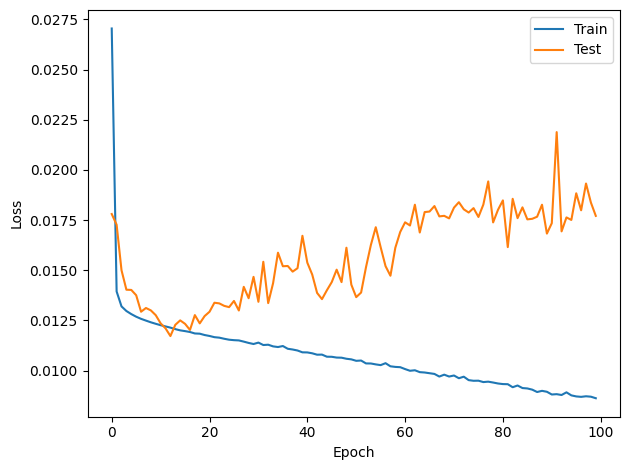

In [17]:
args = SimpleNamespace(**args)
model = model.fit(args)

In [18]:
df.head()

,COUNT(consumptions),MAX(consumptions.CSS_MS_HS_USE),MEAN(consumptions.CSS_MS_HS_USE),MIN(consumptions.CSS_MS_HS_USE),NUM_UNIQUE(consumptions.BS_RATE),NUM_UNIQUE(consumptions.MS_METER_NBR),SKEW(consumptions.CSS_MS_HS_USE),STD(consumptions.CSS_MS_HS_USE),SUM(consumptions.CSS_MS_HS_USE),MODE(consumptions.DAY(MEASUREMENT_DATE)),...,MODE(consumptions.BS_RATE)_40,MODE(consumptions.BS_RATE)_41,MODE(consumptions.BS_RATE)_42,MODE(consumptions.BS_RATE)_43,MODE(consumptions.BS_RATE)_44,MODE(consumptions.BS_RATE)_52,MODE(consumptions.BS_RATE)_53,MODE(consumptions.BS_RATE)_54,MODE(consumptions.BS_RATE)_55,MODE(consumptions.BS_RATE)_other
0,4.0,135.0,64.250000,12.0,1.0,1.0,0.758461,54.389797,257.0,2.0,...,0,0,0,0,0,0,0,0,0,0
1,10.0,127.0,51.900000,0.0,1.0,2.0,0.783315,43.072162,519.0,2.0,...,0,0,0,0,0,0,0,0,0,0
2,12.0,6068.0,3924.166667,2446.0,1.0,1.0,0.574519,1012.516472,47090.0,28.0,...,0,0,0,0,0,0,0,0,0,0
3,6.0,1061.0,479.333333,7.0,2.0,1.0,0.020392,409.340282,2876.0,4.0,...,0,0,0,0,0,0,0,0,0,0
4,24.0,1247.0,536.833333,0.0,2.0,1.0,0.537625,335.364392,12884.0,4.0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
tmp_df = df.copy()

In [20]:
def get_loss_and_hidden(row, model):
    model.eval()
    model.to('cpu') # move model to cpu
    tmp_X = row.drop('target') # get the features
    target = row.target # get the target
    input_tensor = torch.tensor(tmp_X.values, dtype=torch.float32) # transform to torch tensor
    target = torch.tensor(target, dtype=torch.float32)
    
    encoded = model.encode(input_tensor) # get the latent
    decoded = model(input_tensor) # get the prediction
    loss = torch.nn.functional.binary_cross_entropy_with_logits(decoded[0], target) # calculate the loss
    
    return loss.item(), encoded.detach().numpy().tolist()

In [21]:
X = tmp_df.drop(['target'], axis=1)
X = scaler.transform(X)
y = tmp_df['target'].values
cols = list(df.columns)
cols.remove("target")
tmp = pd.DataFrame(X, columns=cols)
tmp['target'] = y

In [22]:
tmp[['loss', 'hidden']] = tmp.apply(lambda row: pd.Series(get_loss_and_hidden(row, model)), axis=1)
tmp.drop(['loss'], axis=1, inplace=True)

In [23]:
tmp.head()

,COUNT(consumptions),MAX(consumptions.CSS_MS_HS_USE),MEAN(consumptions.CSS_MS_HS_USE),MIN(consumptions.CSS_MS_HS_USE),NUM_UNIQUE(consumptions.BS_RATE),NUM_UNIQUE(consumptions.MS_METER_NBR),SKEW(consumptions.CSS_MS_HS_USE),STD(consumptions.CSS_MS_HS_USE),SUM(consumptions.CSS_MS_HS_USE),MODE(consumptions.DAY(MEASUREMENT_DATE)),...,MODE(consumptions.BS_RATE)_42,MODE(consumptions.BS_RATE)_43,MODE(consumptions.BS_RATE)_44,MODE(consumptions.BS_RATE)_52,MODE(consumptions.BS_RATE)_53,MODE(consumptions.BS_RATE)_54,MODE(consumptions.BS_RATE)_55,MODE(consumptions.BS_RATE)_other,target,hidden
0,0.025862,0.000036,0.000064,0.000012,0.00,0.0,0.382790,0.000083,0.000043,0.033333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[-0.48368293046951294, 0.6294888854026794, -0...."
1,0.077586,0.000034,0.000052,0.000000,0.00,0.2,0.384822,0.000066,0.000087,0.033333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[1.0620262622833252, 1.4297322034835815, -0.89..."
2,0.094828,0.001637,0.003924,0.002446,0.00,0.0,0.367747,0.001549,0.007935,0.900000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.394878625869751, 0.93348628282547, -0.77943..."
3,0.043103,0.000286,0.000479,0.000007,0.25,0.0,0.322431,0.000626,0.000485,0.100000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[-1.1152064800262451, -0.954816997051239, 1.25..."
4,0.198276,0.000336,0.000537,0.000000,0.25,0.0,0.364730,0.000513,0.002171,0.100000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[-1.067033290863037, 0.11420591175556183, 0.42..."


In [24]:
len(tmp)

700519

In [25]:
tmp.head()

,COUNT(consumptions),MAX(consumptions.CSS_MS_HS_USE),MEAN(consumptions.CSS_MS_HS_USE),MIN(consumptions.CSS_MS_HS_USE),NUM_UNIQUE(consumptions.BS_RATE),NUM_UNIQUE(consumptions.MS_METER_NBR),SKEW(consumptions.CSS_MS_HS_USE),STD(consumptions.CSS_MS_HS_USE),SUM(consumptions.CSS_MS_HS_USE),MODE(consumptions.DAY(MEASUREMENT_DATE)),...,MODE(consumptions.BS_RATE)_42,MODE(consumptions.BS_RATE)_43,MODE(consumptions.BS_RATE)_44,MODE(consumptions.BS_RATE)_52,MODE(consumptions.BS_RATE)_53,MODE(consumptions.BS_RATE)_54,MODE(consumptions.BS_RATE)_55,MODE(consumptions.BS_RATE)_other,target,hidden
0,0.025862,0.000036,0.000064,0.000012,0.00,0.0,0.382790,0.000083,0.000043,0.033333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[-0.48368293046951294, 0.6294888854026794, -0...."
1,0.077586,0.000034,0.000052,0.000000,0.00,0.2,0.384822,0.000066,0.000087,0.033333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[1.0620262622833252, 1.4297322034835815, -0.89..."
2,0.094828,0.001637,0.003924,0.002446,0.00,0.0,0.367747,0.001549,0.007935,0.900000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.394878625869751, 0.93348628282547, -0.77943..."
3,0.043103,0.000286,0.000479,0.000007,0.25,0.0,0.322431,0.000626,0.000485,0.100000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[-1.1152064800262451, -0.954816997051239, 1.25..."
4,0.198276,0.000336,0.000537,0.000000,0.25,0.0,0.364730,0.000513,0.002171,0.100000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[-1.067033290863037, 0.11420591175556183, 0.42..."


In [26]:
tmp2 = pd.DataFrame(tmp['hidden'].apply(pd.Series).values, columns=[f't_hidden_{i}' for i in range(1, 33)])

In [27]:
tmp3 = pd.concat([tmp, tmp2], axis=1)

In [28]:
tmp3.head()

,COUNT(consumptions),MAX(consumptions.CSS_MS_HS_USE),MEAN(consumptions.CSS_MS_HS_USE),MIN(consumptions.CSS_MS_HS_USE),NUM_UNIQUE(consumptions.BS_RATE),NUM_UNIQUE(consumptions.MS_METER_NBR),SKEW(consumptions.CSS_MS_HS_USE),STD(consumptions.CSS_MS_HS_USE),SUM(consumptions.CSS_MS_HS_USE),MODE(consumptions.DAY(MEASUREMENT_DATE)),...,t_hidden_23,t_hidden_24,t_hidden_25,t_hidden_26,t_hidden_27,t_hidden_28,t_hidden_29,t_hidden_30,t_hidden_31,t_hidden_32
0,0.025862,0.000036,0.000064,0.000012,0.00,0.0,0.382790,0.000083,0.000043,0.033333,...,0.205844,1.182499,1.891355,-0.079143,-0.926229,0.960404,-1.026648,0.384641,-0.114280,-1.592756
1,0.077586,0.000034,0.000052,0.000000,0.00,0.2,0.384822,0.000066,0.000087,0.033333,...,0.227257,0.153013,1.423085,0.785517,-0.071814,-0.675389,-0.822502,0.137586,-0.395882,-0.453680
2,0.094828,0.001637,0.003924,0.002446,0.00,0.0,0.367747,0.001549,0.007935,0.900000,...,0.107579,0.635390,1.674400,0.141925,-0.270644,-0.000179,-0.836043,0.332533,0.597057,-0.819081
3,0.043103,0.000286,0.000479,0.000007,0.25,0.0,0.322431,0.000626,0.000485,0.100000,...,-0.366606,1.078250,1.441429,-0.532763,-0.785618,0.385400,0.192558,-0.607722,0.067307,-0.190192
4,0.198276,0.000336,0.000537,0.000000,0.25,0.0,0.364730,0.000513,0.002171,0.100000,...,-1.063543,0.551387,1.128645,0.542634,-0.763241,-0.080599,0.250196,-0.304568,0.257681,-0.521283


In [29]:
tmp3.drop(['hidden'], axis=1, inplace=True)

In [30]:
tmp3.head()

,COUNT(consumptions),MAX(consumptions.CSS_MS_HS_USE),MEAN(consumptions.CSS_MS_HS_USE),MIN(consumptions.CSS_MS_HS_USE),NUM_UNIQUE(consumptions.BS_RATE),NUM_UNIQUE(consumptions.MS_METER_NBR),SKEW(consumptions.CSS_MS_HS_USE),STD(consumptions.CSS_MS_HS_USE),SUM(consumptions.CSS_MS_HS_USE),MODE(consumptions.DAY(MEASUREMENT_DATE)),...,t_hidden_23,t_hidden_24,t_hidden_25,t_hidden_26,t_hidden_27,t_hidden_28,t_hidden_29,t_hidden_30,t_hidden_31,t_hidden_32
0,0.025862,0.000036,0.000064,0.000012,0.00,0.0,0.382790,0.000083,0.000043,0.033333,...,0.205844,1.182499,1.891355,-0.079143,-0.926229,0.960404,-1.026648,0.384641,-0.114280,-1.592756
1,0.077586,0.000034,0.000052,0.000000,0.00,0.2,0.384822,0.000066,0.000087,0.033333,...,0.227257,0.153013,1.423085,0.785517,-0.071814,-0.675389,-0.822502,0.137586,-0.395882,-0.453680
2,0.094828,0.001637,0.003924,0.002446,0.00,0.0,0.367747,0.001549,0.007935,0.900000,...,0.107579,0.635390,1.674400,0.141925,-0.270644,-0.000179,-0.836043,0.332533,0.597057,-0.819081
3,0.043103,0.000286,0.000479,0.000007,0.25,0.0,0.322431,0.000626,0.000485,0.100000,...,-0.366606,1.078250,1.441429,-0.532763,-0.785618,0.385400,0.192558,-0.607722,0.067307,-0.190192
4,0.198276,0.000336,0.000537,0.000000,0.25,0.0,0.364730,0.000513,0.002171,0.100000,...,-1.063543,0.551387,1.128645,0.542634,-0.763241,-0.080599,0.250196,-0.304568,0.257681,-0.521283


In [31]:
final = tmp3[['t_hidden_1', 't_hidden_2', 't_hidden_3', 't_hidden_4',
          't_hidden_5', 't_hidden_6', 't_hidden_7', 't_hidden_8',
          't_hidden_9', 't_hidden_10', 't_hidden_11', 't_hidden_12',
          't_hidden_13', 't_hidden_14', 't_hidden_15', 't_hidden_16',#]]
          't_hidden_17', 't_hidden_18', 't_hidden_19', 't_hidden_20',
          't_hidden_21', 't_hidden_22', 't_hidden_23', 't_hidden_24',
          't_hidden_25', 't_hidden_26', 't_hidden_27', 't_hidden_28',
          't_hidden_29', 't_hidden_30', 't_hidden_31', 't_hidden_32']]
          #'t_hidden_33', 't_hidden_34', 't_hidden_35', 't_hidden_36',
          #'t_hidden_37', 't_hidden_38', 't_hidden_39', 't_hidden_40',
          #'t_hidden_41', 't_hidden_42', 't_hidden_43', 't_hidden_44',
          #'t_hidden_45', 't_hidden_46', 't_hidden_47', 't_hidden_48',
          #'t_hidden_49', 't_hidden_50', 't_hidden_51', 't_hidden_52',
          #'t_hidden_53', 't_hidden_54', 't_hidden_55', 't_hidden_56',
          #'t_hidden_57', 't_hidden_58', 't_hidden_59', 't_hidden_60',
          #'t_hidden_61', 't_hidden_62', 't_hidden_63', 't_hidden_64']]

In [32]:
len(df), len(final)

(700519, 700519)

In [33]:
final.to_csv("autoencoder_classifier_loss_encoded_new2.csv", index=False)

In [34]:
model

AutoEncoder(
  (encoder): MLP(
    (MLP): Sequential(
      (0): Linear(in_features=88, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=32, bias=True)
    )
  )
  (decoder): MLP(
    (MLP): Sequential(
      (0): Linear(in_features=32, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=88, bias=True)
    )
  )
  (classifier): MLP(
    (MLP): Sequential(
      (0): Linear(in_features=88, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=64, bias=True)
      (3): ReLU()
      (4): Linear(in_features=64, out_features=1, bias=True)
    )
  )
)

In [35]:
torch.save(model.state_dict(), "../checkpoints/autoencoder_classifier.pth")

In [36]:
import joblib
scaler_filename = "../checkpoints/minmax_scaler.joblib"
joblib.dump(scaler, scaler_filename) 

['../checkpoints/minmax_scaler.joblib']

In [48]:
model.encoder.MLP

Sequential(
  (0): Linear(in_features=88, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=32, bias=True)
)

In [56]:
model.encoder.MLP[0].weight

Parameter containing:
tensor([[-0.4329, -1.4976, -1.0692,  ...,  0.2815, -0.0571,  0.0027],
        [ 0.0368,  1.2660,  0.8166,  ..., -0.1324, -0.0947, -0.4421],
        [ 0.0137, -0.0112,  0.1332,  ..., -0.3050, -0.1187, -0.3729],
        ...,
        [-0.1146, -0.3185,  0.2643,  ...,  0.0496,  0.0541,  0.7581],
        [-0.0111, -0.8712, -0.5375,  ...,  0.9057,  0.4082,  1.1457],
        [-0.4022,  0.5564, -0.6535,  ...,  0.5270,  0.1689,  0.2248]],
       requires_grad=True)